In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3 import Model, Normal, GaussianRandomWalk, HalfNormal
from pymc3 import NUTS, sample
from scipy import optimize
from pymc3 import traceplot
from pymc3 import summary
import theano.tensor as tt
import theano as T

df = pd.read_csv("../data/data-ss2.txt")
T = df.values[:,0].astype(np.float32)
Y = df.values[:,1].astype(np.float32)

n_times = len(df["X"].unique()) #時間の数
L = 4 #トレンド周期

basic_model = Model()

#subtensorの使い方↓
#http://deeplearning.net/software/theano/library/tensor/basic.html

with basic_model:
    #事前分布
    s_mu = HalfNormal('s_mu', sd=100) #隣接時刻の状態の誤差
    s_season = HalfNormal('s_season', sd=100) #季節誤差
    s_Y =  HalfNormal('s_Y', sd=100) #各時刻における状態と観測の誤差
    season_0_1_2 = Normal('season_0_1_2',mu=0, sd=100, shape=3) #季節項の誤差なし初期値
    
    #季節process 
    #まず初期状態の代入
    season = tt.zeros((n_times))
    for i in list(range(L-1)):
        season = tt.set_subtensor(season[i], season_0_1_2[i])
    
    #初期状態以降の代入
    for t in list(range(n_times - 3)):
        # sum^{L-1}_{l=1} -season[t-l] のテンソルを作成
        Sigma = tt.zeros((1))
        for l in list(range(L-1)):
            Sigma +=  season[(t+3)-l]
        Sigma = Sigma
        
        # 時刻 t+3 の(誤差なし)状態を代入
        season =tt.set_subtensor(season[t+3], -Sigma[0])  

    #誤差を追加
    season = Normal("season", mu=season , sd=s_season, shape=44)
    
    #状態process
    mu = GaussianRandomWalk("mu",s_mu, shape=n_times )
        
    #likelihood
    Y_obs = Normal('Y_obs', mu=mu+season, sd=s_Y, observed=Y)

    #サンプリング
    trace = sample(1000)
    summary(trace)
    


0
0
1
2
1
0
1
2
2
0
1
2
3
0
1
2
4
0
1
2
5
0
1
2
6
0
1
2
7
0
1
2
8
0
1
2
9
0
1
2
10
0
1
2
11
0
1
2
12
0
1
2
13
0
1
2
14
0
1
2
15
0
1
2
16
0
1
2
17
0
1
2
18
0
1
2
19
0
1
2
20
0
1
2
21
0
1
2
22
0
1
2
23
0
1
2
24
0
1
2
25
0
1
2
26
0
1
2
27
0
1
2
28
0
1
2
29
0
1
2
30
0
1
2
31
0
1
2
32
0
1
2
33
0
1
2
34
0
1
2
35
0
1
2
36
0
1
2
37
0
1
2
38
0
1
2
39
0
1
2
40
0
1
2
season_print __str__ = 0.0
season_shape_print __str__ = 44


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -228.35: 100%|██████████| 200000/200000 [02:39<00:00, 1256.55it/s]
Finished [100%]: Average ELBO = -227.47
100%|██████████| 1000/1000 [02:39<00:00, 11.37it/s]


season_0_1_2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.274            5.151            0.214            [-9.827, 10.624]
  0.263            0.923            0.038            [-1.388, 2.177]
  0.488            1.032            0.041            [-1.686, 2.344]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -10.415        -3.145         0.485          3.617          10.151
  -1.429         -0.342         0.247          0.887          2.152
  -1.618         -0.173         0.529          1.153          2.534


season:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.392            3.102            0.151            [-5.503, 6.382]
  4.582            2.591            0.140      

In [2]:
traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12267b588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121d646d8>]], dtype=object)

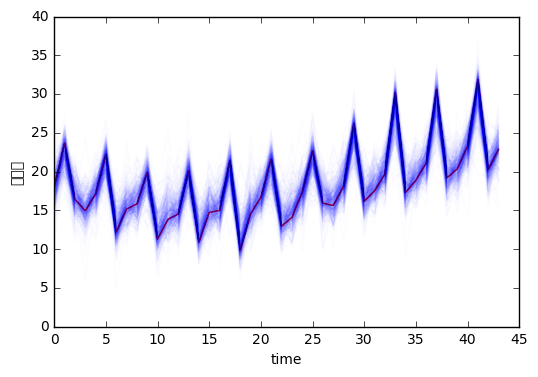

In [6]:
%matplotlib inline
plt.plot(df.values[:,1],"r")
plt.plot(trace["season",500:].T + trace["mu",500:].T , 'b', alpha=.01)
plt.xlabel('time')
plt.ylabel('販売数')